In [1]:
# Deutsch algorithm (도이치 알고리즘)

from qiskit import QuantumCircuit

def deutsch_function(case: int):
    """
    Generate a valid Deutsch function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

def compile_circuit(function: QuantumCircuit):
    """
    Compiles a circuit for use in Deutsch's algorithm.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

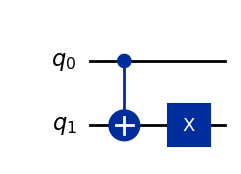

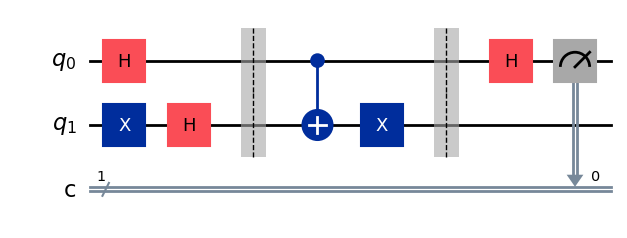

In [3]:
display(deutsch_function(3).draw('mpl'))
display(compile_circuit(deutsch_function(3)).draw('mpl'))

In [4]:
from qiskit_aer import AerSimulator

def deutsch_algorithm(function: QuantumCircuit):
    """
    Determine if a Deutsch function is constant or balanced.
    """
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

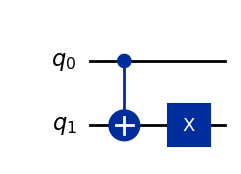

'balanced'

In [6]:
f = deutsch_function(3)
display(f.draw('mpl'))
display(deutsch_algorithm(f))

In [11]:
# Deutsch-Jozsa algorithm (도이치-조사 알고리즘)

from qiskit import QuantumCircuit
import numpy as np

def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """

    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # next, choose half the possible input states
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

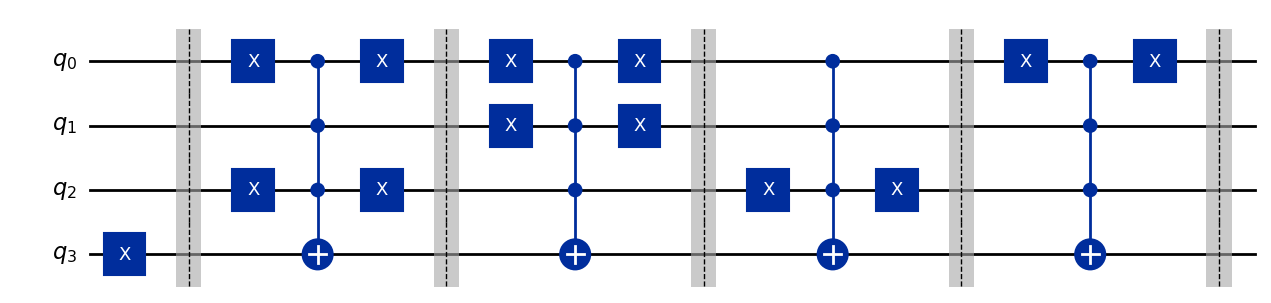

In [16]:
display(dj_function(3).draw('mpl'))

In [17]:
def compile_circuit(function: QuantumCircuit):
    """
    Compiles a circuit for use in the Deutsch-Jozsa algorithm.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [18]:
from qiskit_aer import AerSimulator

def dj_algorithm(function: QuantumCircuit):
    """
    Determine if a Deutsch-Jozsa function is constant or balanced.
    """
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

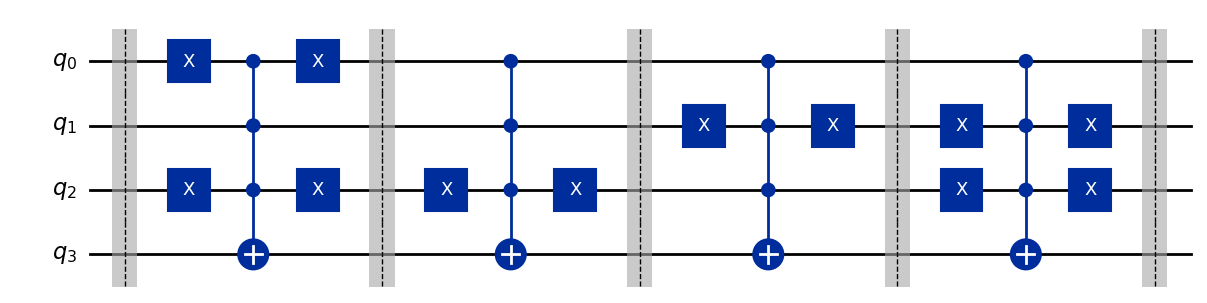

'balanced'

In [22]:
f = dj_function(3)
display(f.draw('mpl'))
display(dj_algorithm(f))

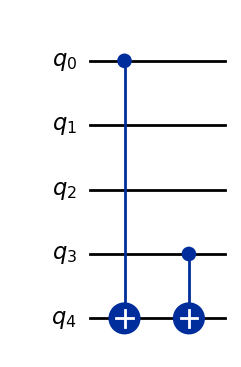

'1001'

In [27]:
# The Bernstein-Vazirani problem using Deutsch-Jozsa algorithm

def bv_function(s):
    """
    Create a Bernstein-Vazirani function from a string of 1s and 0s.
    """
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]


display(bv_function("1001").draw('mpl'))
display(bv_algorithm(bv_function("1001")))



In [2]:
# Simon's algorithm

# import random
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
import numpy as np

def simon_function(s: str):
    """
    Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    # Our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which
    # is a simple function that satisfies the promise, and then we take f to be the composition of g and the random
    # permutation pi. This gives us a random function satisfying the promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [3]:
from qiskit_aer import AerSimulator
from qiskit import ClassicalRegister

def simon_measurements(problem: QuantumCircuit, k: int):
    """
    Quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get `k` measurements to be post-processed later.
    """
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

display(simon_measurements(simon_function("11011"),k=12))

['10101',
 '11111',
 '00011',
 '00000',
 '01101',
 '00011',
 '01101',
 '01010',
 '10110',
 '10110',
 '00100',
 '11100']

In [4]:
import numpy as np
import galois

def simon_algorithm(problem: QuantumCircuit):
    """
    Given a `QuantumCircuit` that implements a query gate for Simon problem, return the hidden string `s`.
    """

    # Quantum part: run the circuit defined previously k times and gather the measurement results.
    # Replace +10 by +r for any nonnegative integer r depending on desired confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)
    print("Measurement results:")
    display(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:")
    display(null_space)

    # 3. Convert back to a string
    print("Guess for hidden string s:")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

display(simon_algorithm(simon_function("10011")))

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.